In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Sun Jun 12 18:05:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   39C    P8    21W / 260W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 29%   

# MongoDB

In [4]:
from pymongo import MongoClient
import pymongo

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_de = db.patent_de
    # db_us = db.patent_us
    # db_cn = db.patent_cn

    db_rm_cn_2018 = db.rm_patent_cn_2018
    db_rm_us_2018 = db.rm_patent_us_2018
    db_rm_de_2018 = db.rm_patent_de_2018

    
except errors.ConnectionFailure as err:
    print(err)

# 2018

## Company數量

In [6]:
data_assignee = db_rm_de_2018.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])

In [7]:
df_family_de = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [8]:
data_assignee = db_rm_cn_2018.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [9]:
data_assignee = db_rm_us_2018.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [10]:
final_df = pd.concat([df_family_de,df_family_cn,df_family_us],axis=0)

In [11]:
# 取總數前15家公司
final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

,company,count
52,Qualcomm Inc,1153
56,Samsung Electronics Co Ltd,856
68,Telefonaktiebolaget LM Ericsson AB,509
36,Intel Corp,471
38,International Business Machines Corp,346
31,Huawei Technologies Co Ltd,331
3,Apple Inc,220
14,Cisco Technology Inc,196
72,Xian Irain IoT Technology Service Co Ltd,177
45,Microsoft Technology Licensing LLC,164


In [12]:
com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_df.reset_index(drop=True, inplace=True)

In [13]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))
com_df

,company,count,count_log
0,Qualcomm Inc,1153,7.050123
1,Samsung Electronics Co Ltd,856,6.752270
2,Telefonaktiebolaget LM Ericsson AB,509,6.232448
3,Intel Corp,471,6.154858
4,International Business Machines Corp,346,5.846439
5,Huawei Technologies Co Ltd,331,5.802118
6,Apple Inc,220,5.393628
7,Cisco Technology Inc,196,5.278115
8,Xian Irain IoT Technology Service Co Ltd,177,5.176150
9,Microsoft Technology Licensing LLC,164,5.099866


In [14]:
com_ls = list(com_df.company)

## Data

In [15]:
ccontry = pd.read_csv("./final_data/rm_company_country_all_2018.csv")
ccpc = pd.read_csv("./final_data/rm_company_cpc_all_2018.csv")

In [16]:
ccontry[ccontry.company.isin(com_ls)].head()

,company,AP,AR,AT,AU,BE,BR,CA,CL,CN,...,PT,RO,RU,SE,SG,TN,TR,TW,US,ZA
163,Apple Inc,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,205.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,308.0,0.0
675,Cisco Technology Inc,0.0,0.0,0.0,2.0,0.0,0.0,8.0,0.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0,0.0
1478,Huawei Technologies Co Ltd,0.0,0.0,0.0,16.0,0.0,29.0,13.0,0.0,332.0,...,0.0,0.0,5.0,0.0,2.0,0.0,0.0,0.0,186.0,0.0
1619,Intel Corp,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,234.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,548.0,0.0
1633,International Business Machines Corp,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,354.0,0.0


## Similarity計算

### Country

- 換成機率  

In [17]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

### PBC
- 和Samsung Electronics Co Ltd比較

In [18]:
ccontry_pbc = ccontry2.loc[com_ls,:].copy()
ccontry_pbc.head()

,AP,AR,AT,AU,BE,BR,CA,CL,CN,CO,...,PT,RO,RU,SE,SG,TN,TR,TW,US,ZA
company,,,,,,,,,,,,,,,,,,,,,
Qualcomm Inc,0.00000,0.000804,0.0,0.010446,0.0,0.068301,0.027320,0.003013,0.193652,0.003013,...,0.000000,0.0,0.001808,0.0,0.039976,0.000201,0.00000,0.093411,0.228807,0.000000
Samsung Electronics Co Ltd,0.00000,0.000000,0.0,0.011071,0.0,0.000357,0.003571,0.000000,0.203214,0.000000,...,0.000357,0.0,0.000714,0.0,0.002857,0.000000,0.00000,0.010000,0.298929,0.000000
Telefonaktiebolaget LM Ericsson AB,0.00058,0.017411,0.0,0.009867,0.0,0.035403,0.011608,0.001741,0.151480,0.007545,...,0.005223,0.0,0.034823,0.0,0.001741,0.000000,0.00058,0.009286,0.284388,0.011027
Intel Corp,0.00000,0.000000,0.0,0.000869,0.0,0.002606,0.000000,0.000000,0.203301,0.000000,...,0.000000,0.0,0.000000,0.0,0.001738,0.000000,0.00000,0.003475,0.476108,0.000000
International Business Machines Corp,0.00000,0.000000,0.0,0.000000,0.0,0.002404,0.000000,0.000000,0.057692,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.850962,0.000000


In [19]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### CPC

In [20]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [21]:
ccpc_pbc = ccpc2.loc[com_ls,:].copy()
# ccpc_pbc

In [22]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

## Scatter Plot

In [23]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

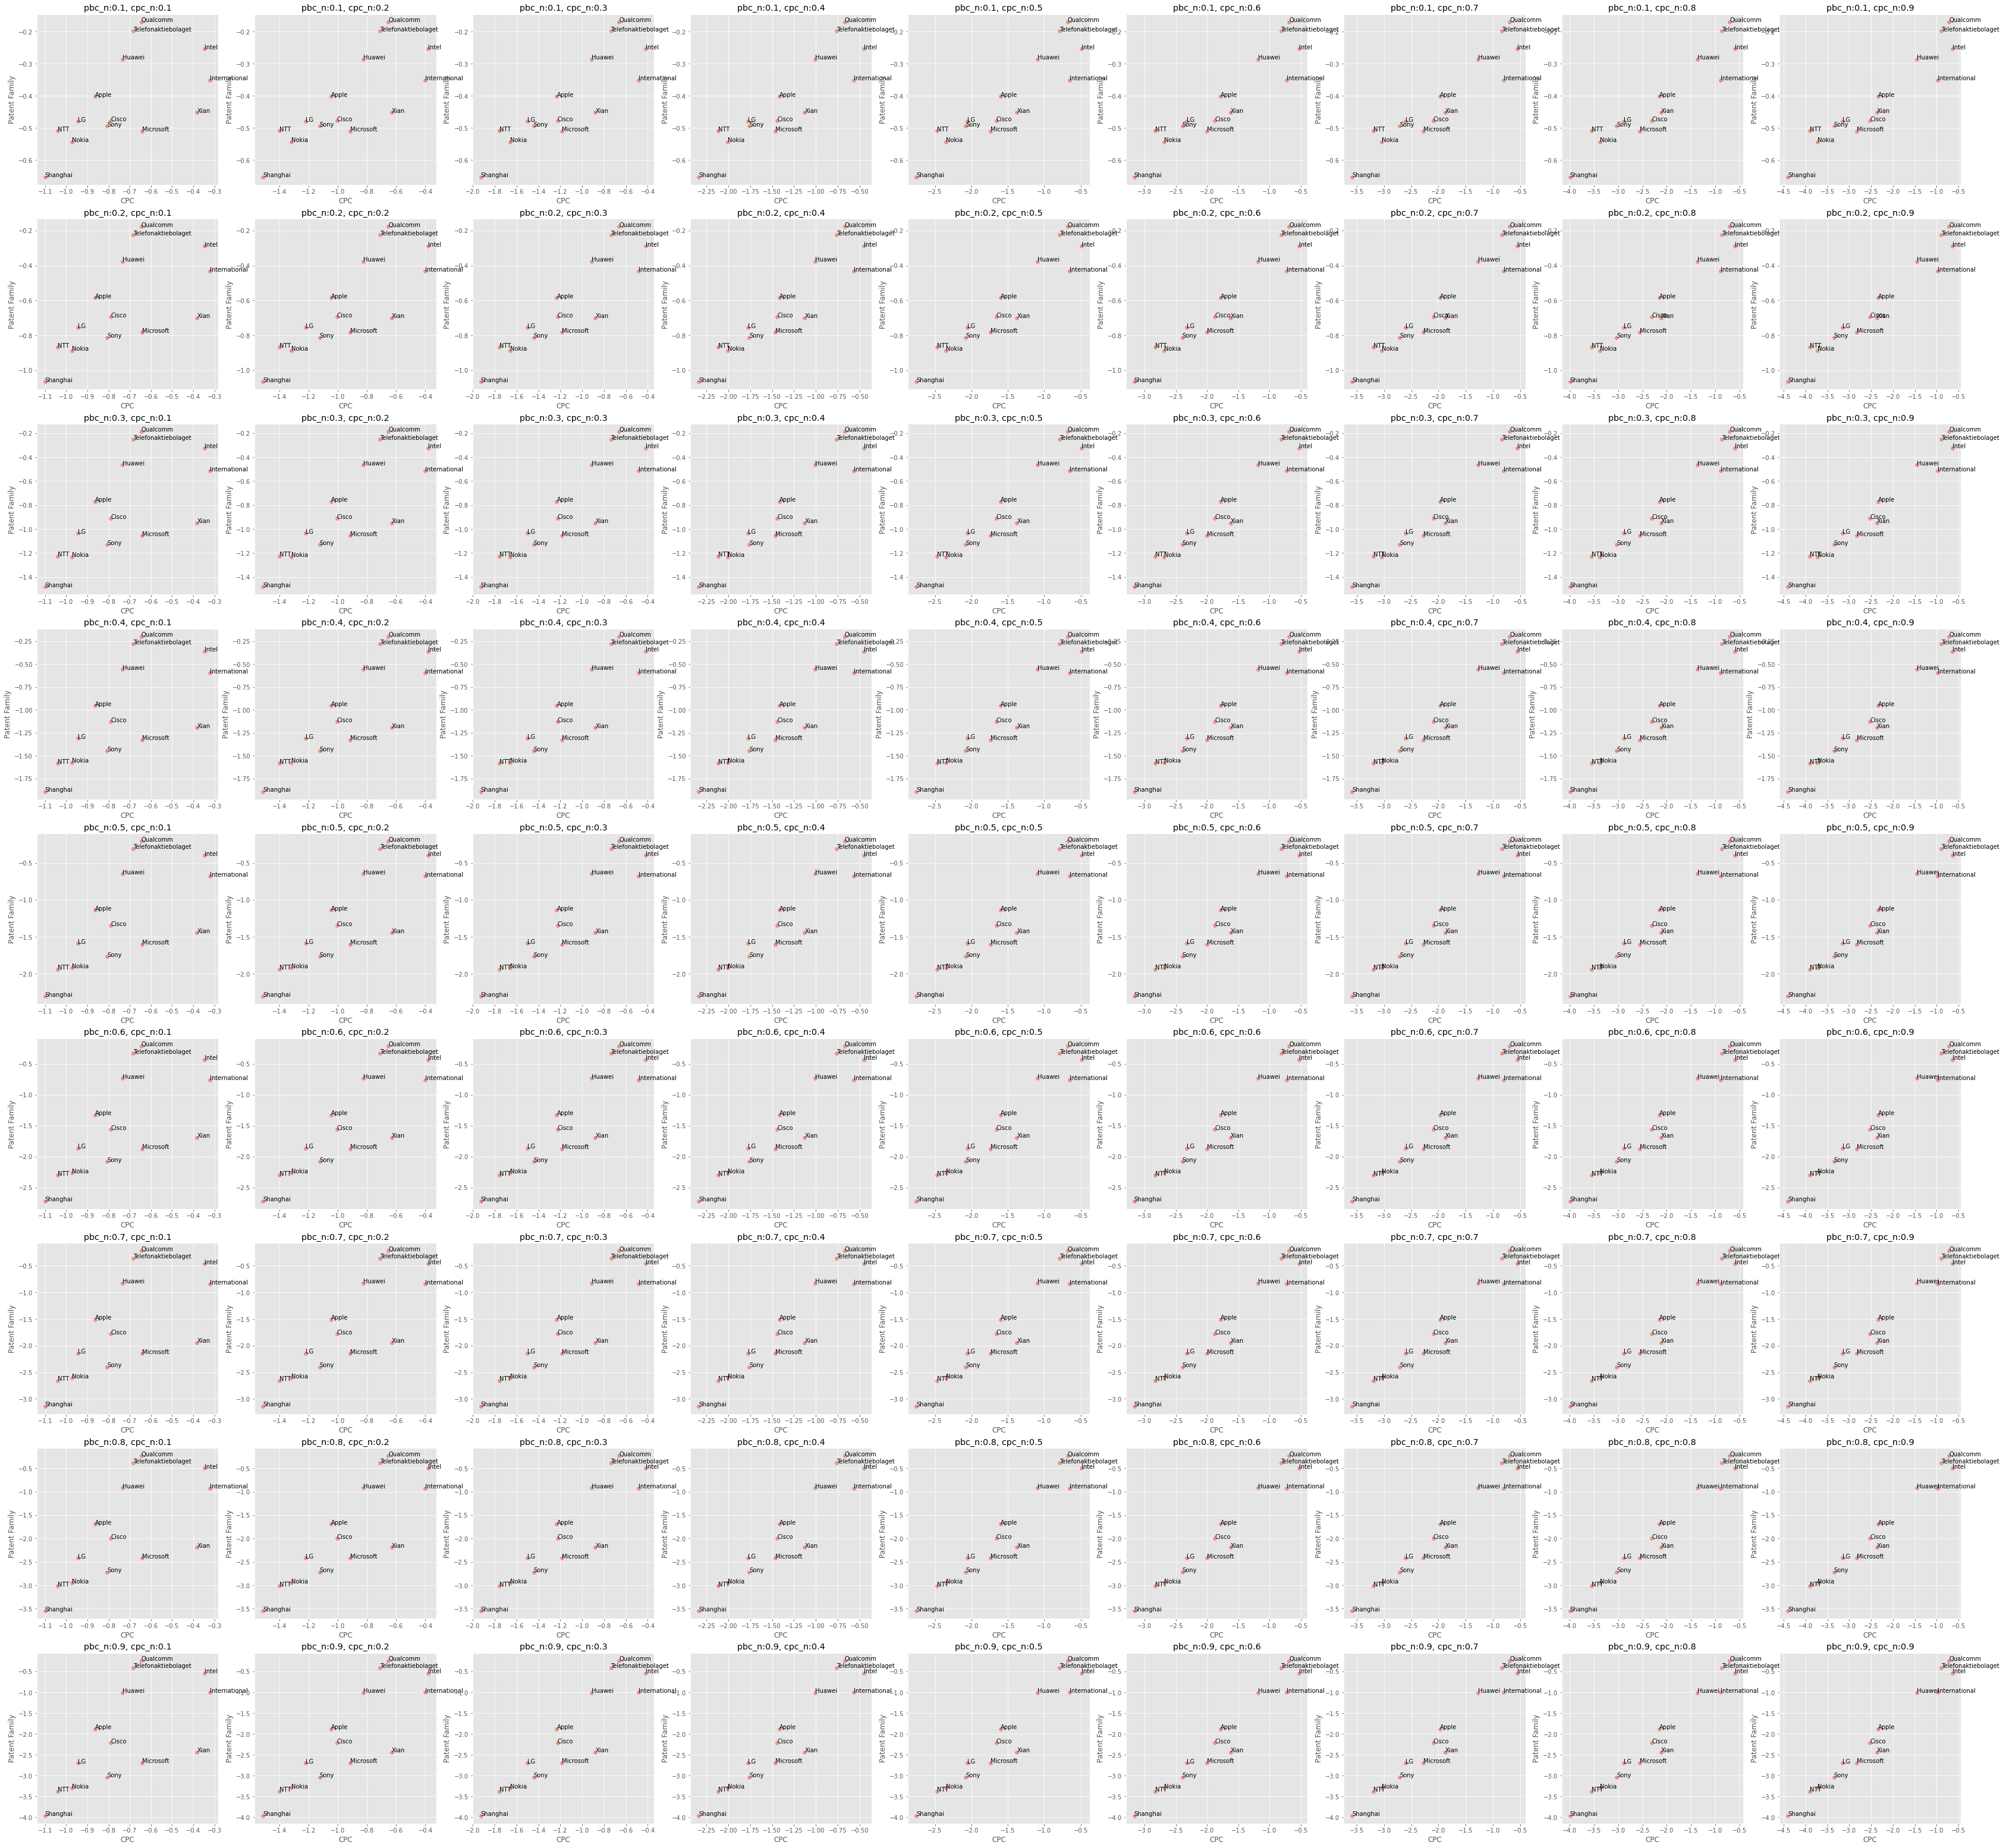

In [24]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_all_2018_1.png'.format(pbc_n))

In [25]:
c_df

,cpc,country
company,,
Qualcomm Inc,0.715389,0.240064
Telefonaktiebolaget LM Ericsson AB,0.898948,0.414187
Intel Corp,0.632273,0.539107
International Business Machines Corp,0.976728,1.006974
Huawei Technologies Co Ltd,1.457848,1.008158
Apple Inc,2.339434,1.878648
Cisco Technology Inc,2.527571,2.216782
Xian Irain IoT Technology Service Co Ltd,2.369402,2.438955
Microsoft Technology Licensing LLC,2.826231,2.694344


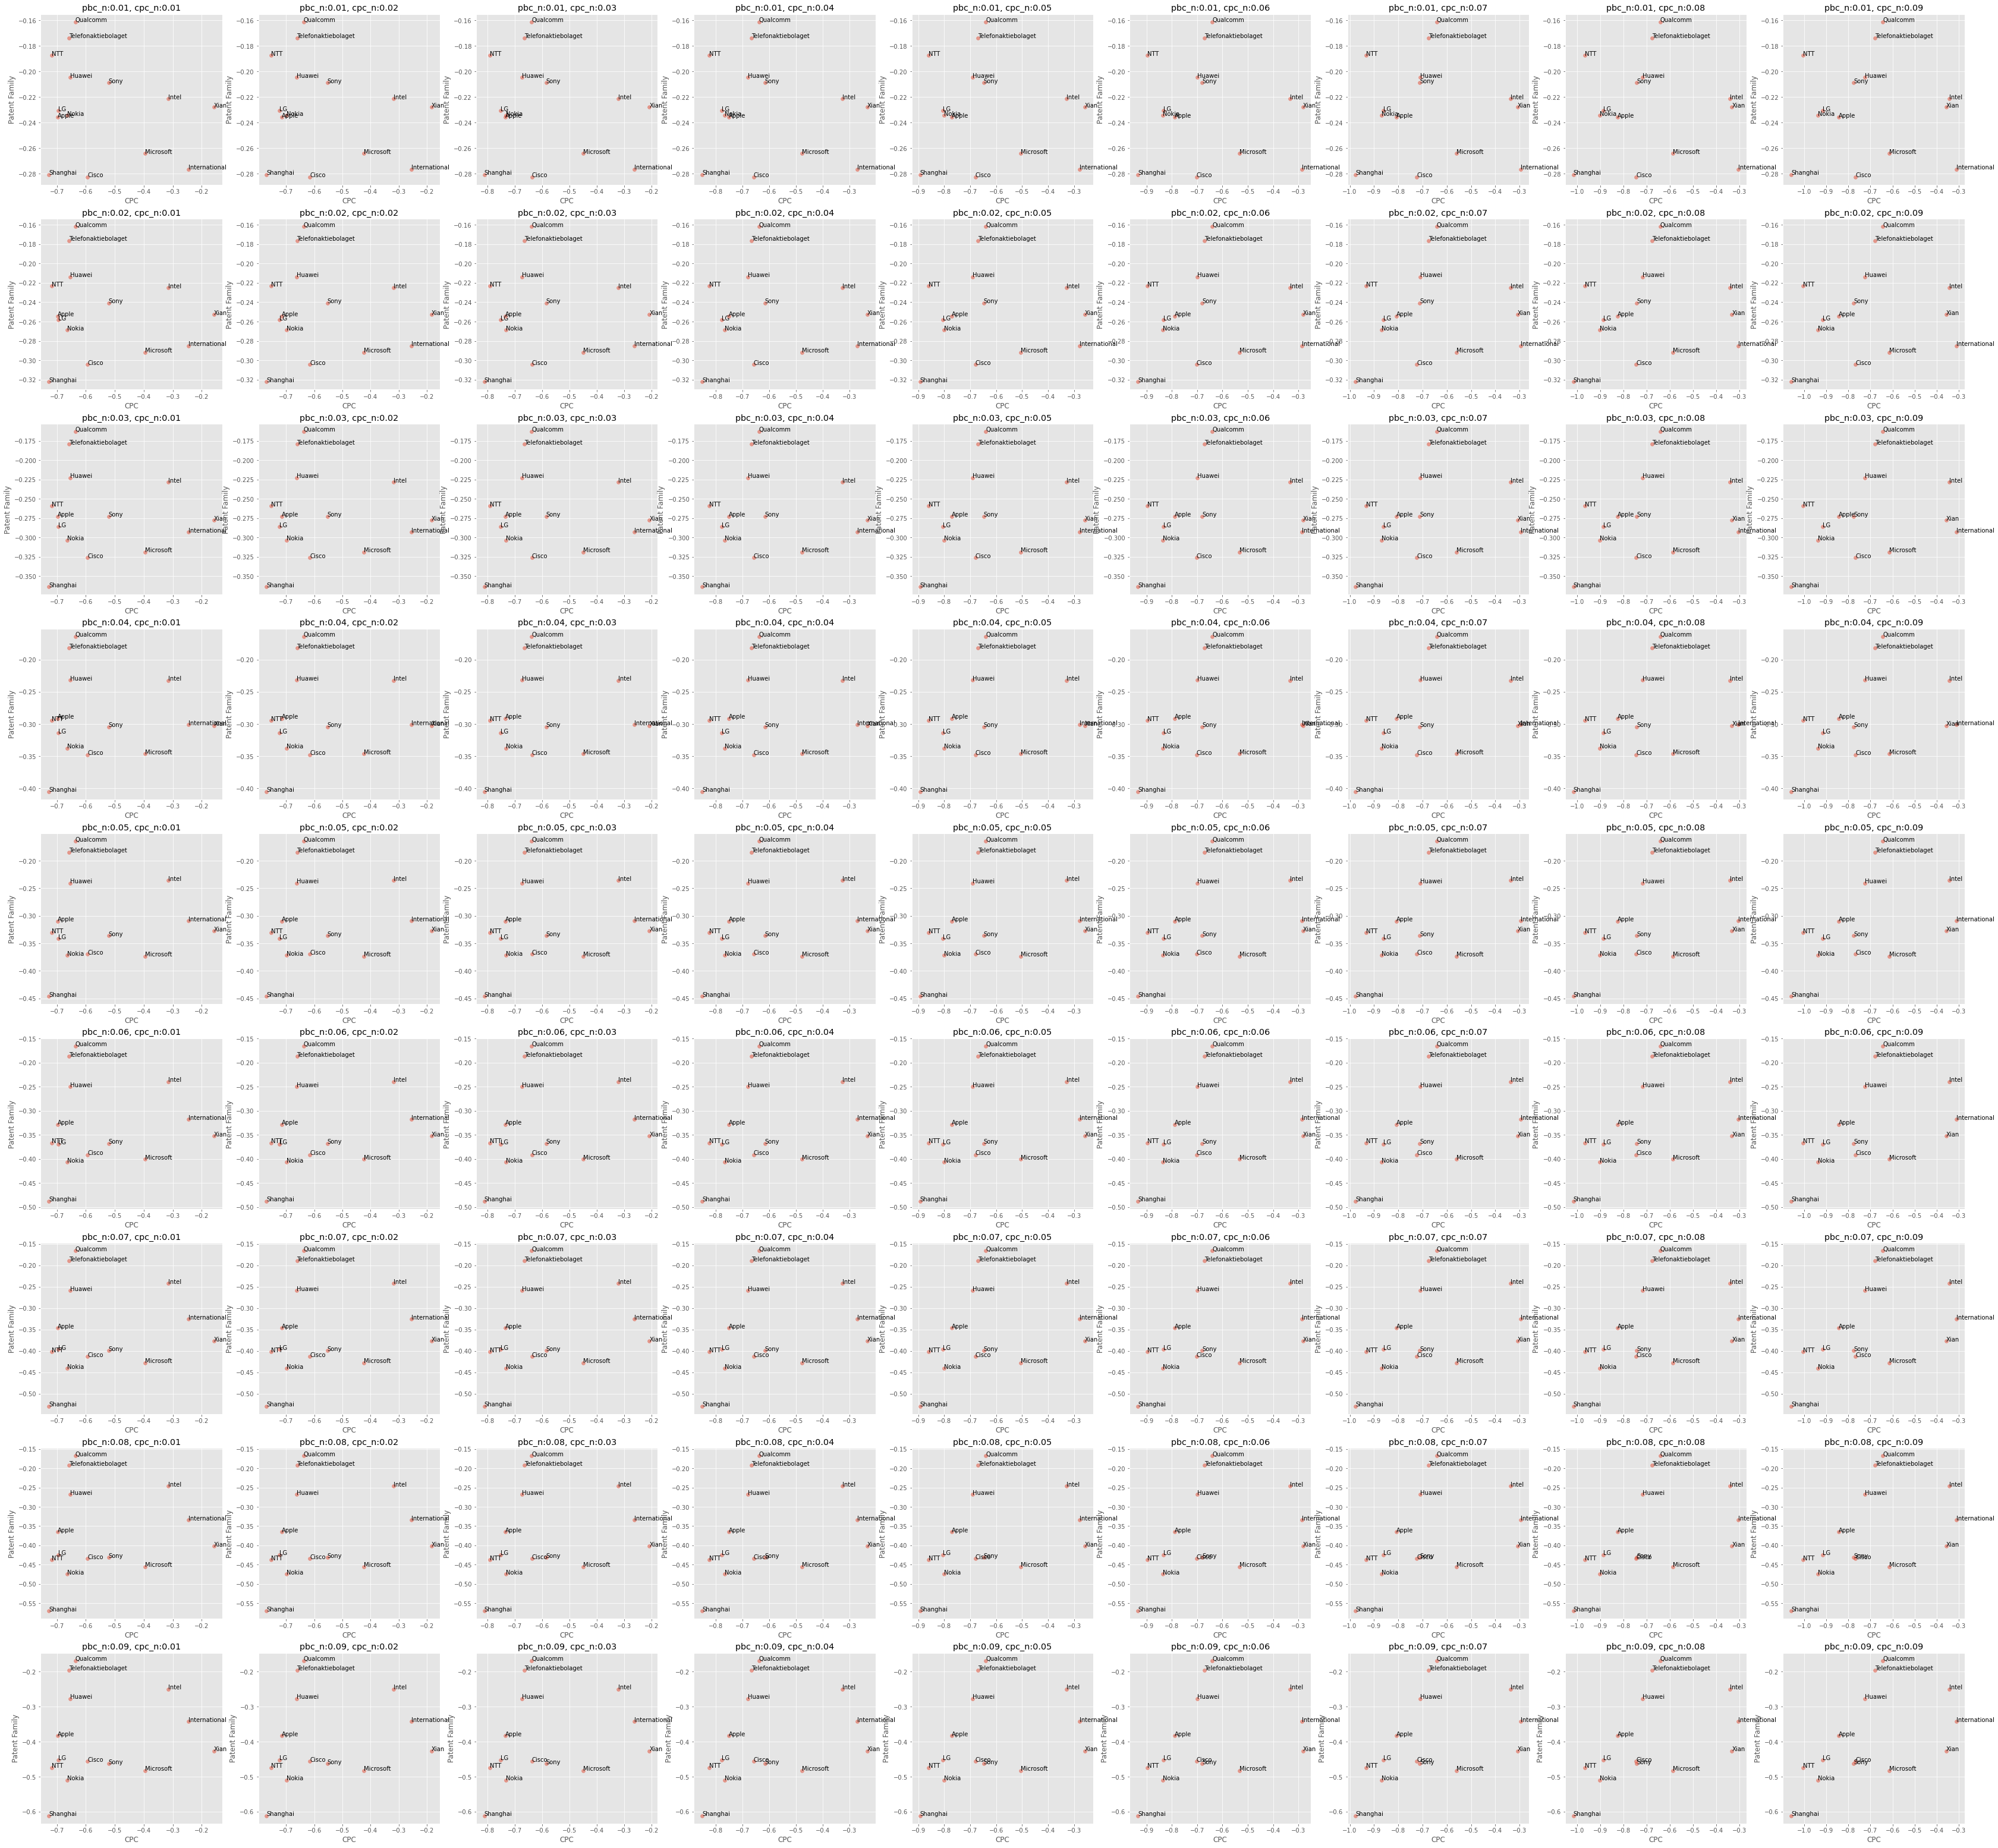

In [26]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_all_2018_2.png'.format(pbc_n))

In [27]:
c_df

,cpc,country
company,,
Qualcomm Inc,0.643529,0.168204
Telefonaktiebolaget LM Ericsson AB,0.680074,0.195312
Intel Corp,0.343183,0.250017
International Business Machines Corp,0.312098,0.342344
Huawei Technologies Co Ltd,0.726589,0.276899
Apple Inc,0.844246,0.383461
Cisco Technology Inc,0.767332,0.456542
Xian Irain IoT Technology Service Co Ltd,0.357235,0.426788
Microsoft Technology Licensing LLC,0.614576,0.482689


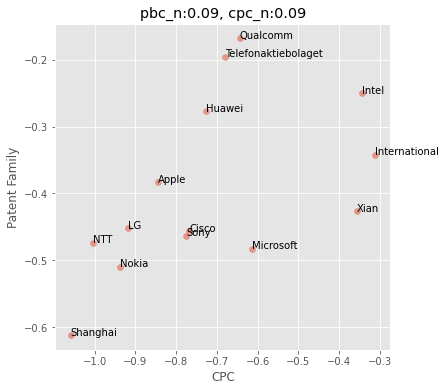

In [34]:
plt.figure(figsize=(6,6))
plt.style.use('ggplot')

pbc_n = 0.09
cpc_n = 0.09
c_df = scatter_plot(pbc_n,cpc_n)
c_df = c_df.drop("Samsung Electronics Co Ltd")

#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("CPC")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [35]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [36]:
competitor_ls

[1, 1, 1, 1, 2, 2, 4, 3, 3, 4, 4, 4, 4, 4]

In [37]:
c_df

,cpc,country
company,,
Qualcomm Inc,0.643529,0.168204
Telefonaktiebolaget LM Ericsson AB,0.680074,0.195312
Intel Corp,0.343183,0.250017
International Business Machines Corp,0.312098,0.342344
Huawei Technologies Co Ltd,0.726589,0.276899
Apple Inc,0.844246,0.383461
Cisco Technology Inc,0.767332,0.456542
Xian Irain IoT Technology Service Co Ltd,0.357235,0.426788
Microsoft Technology Licensing LLC,0.614576,0.482689
